### Loading the data

In [7]:
#load conflict_clean.csv
import pandas as pd
conflict = pd.read_csv('/Users/lauravochita/PycharmProjects/DSFundamentals/UN-General-Debate-Analysis-SDGs/data/processed/conflict_clean.csv')
conflict.head()

,Unnamed: 0,conflict_id,location,incompatibility,year,intensity_level,type_of_conflict,region
0,0,200,Bolivia,2,1946,2,3,5
1,1,200,Bolivia,2,1949,1,3,5
2,2,200,Bolivia,2,1952,1,3,5
3,3,200,Bolivia,2,1967,1,3,5
4,4,201,Cambodia (Kampuchea),1,1946,1,1,3


In [18]:
#load happiness_clean.csv
happiness = pd.read_csv('/Users/lauravochita/PycharmProjects/DSFundamentals/UN-General-Debate-Analysis-SDGs/data/processed/happiness_clean.csv')
happiness.head()

,Unnamed: 0,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157


In [12]:
#load UNGDC_1946-2023_processed.parquet
ungdc = pd.read_parquet('/Users/lauravochita/PycharmProjects/DSFundamentals/UN-General-Debate-Analysis-SDGs/data/processed/UNGDC_1946-2023_processed.parquet')
ungdc.head()

,Session,Year,Country Code,Content
0,01,1946,ARG,At the resumption of the first session of the ...
1,01,1946,AUS,The General Assembly of the United Nations is ...
2,01,1946,BEL,The\tprincipal organs of the United Nations ha...
3,01,1946,BLR,As more than a year has elapsed since the Unit...
4,01,1946,BOL,Coming to this platform where so many distingu...


## EDA

### 1. Are there any visible trends in the sentiment of the UN speeches of countries which are in armed conflict at the time of the speech?

#### 1.1. Identify countries in conflict (years 2005-2022) and match with UN speeches

In [21]:
#check datatype of year column in ungdc dataframe
ungdc['Year'].dtype
#convert year column to integer
ungdc['Year'] = pd.to_numeric(ungdc['Year'], errors='coerce')

#check if conversion was successful
print(ungdc['Year'].dtype)


int64


In [28]:
#standardise the ungdc dataframe column 'Year' to 'year'
ungdc.rename(columns={'Year': 'year'}, inplace=True)
ungdc.head()

,Session,year,Country Code,Content
0,01,1946,ARG,At the resumption of the first session of the ...
1,01,1946,AUS,The General Assembly of the United Nations is ...
2,01,1946,BEL,The\tprincipal organs of the United Nations ha...
3,01,1946,BLR,As more than a year has elapsed since the Unit...
4,01,1946,BOL,Coming to this platform where so many distingu...


In [25]:
import pycountry

#create a function to map country names to country codes
def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

#apply mapping to the conflict and happiness dataframe
conflict['Country Code'] = conflict['location'].apply(get_country_code)
happiness['Country Code'] = happiness['Country name'].apply(get_country_code)

#check the result
print(conflict[['location', 'Country Code']].head())
print(happiness[['Country name', 'Country Code']].head())


               location Country Code
0               Bolivia          BOL
1               Bolivia          BOL
2               Bolivia          BOL
3               Bolivia          BOL
4  Cambodia (Kampuchea)         None
  Country name Country Code
0  Afghanistan          AFG
1  Afghanistan          AFG
2  Afghanistan          AFG
3  Afghanistan          AFG
4  Afghanistan          AFG


In [30]:
#filter conflict and ungdc dataframes for the years 2005-2022
conflict_filtered = conflict[(conflict['year'] >= 2005) & (conflict['year'] <= 2022)]
ungdc_filtered = ungdc[(ungdc['year'] >= 2005) & (ungdc['year'] <= 2022)]

#merge the two dataframes based on the country code and year
conflict_speeches = pd.merge(ungdc_filtered, conflict_filtered,
                             on=['Country Code', 'year'], how='inner')

#check the merged result
print(conflict_speeches.head())


  Session  year Country Code  \
0      60  2005          AFG   
1      60  2005          AZE   
2      60  2005          BDI   
3      60  2005          BGD   
4      60  2005          COL   

                                             Content  Unnamed: 0  conflict_id  \
0  I have the honour\nto inform the members of th...        1676          333   
1  At the outset I\nwould like to congratulate yo...        2150          388   
2  It is a\ndistinct honour to address this Assem...        1018          287   
3  I wish to congratulate\nyou, Mr. President, on...        2475        11350   
4  We\ncongratulate you, Sir, on your election an...        1110          289   

      location  incompatibility  intensity_level  type_of_conflict region  
0  Afghanistan                2                2                 4      3  
1   Azerbaijan                1                1                 4      1  
2      Burundi                2                1                 3      4  
3   Bangladesh  

#### 1.2. Analyse the sentiment of the speeches

In [31]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

#apply the sentiment function to the 'Content' column
conflict_speeches['sentiment'] = conflict_speeches['Content'].apply(get_sentiment)


In [32]:
#group by year and calculate the average sentiment
conflict_sentiment = conflict_speeches.groupby('year')['sentiment'].mean().reset_index()

In [57]:
#show sentiment range
print(conflict_sentiment['sentiment'].min())

0.0896559500725644


#### 1.3. Visualise the sentiment of the speeches

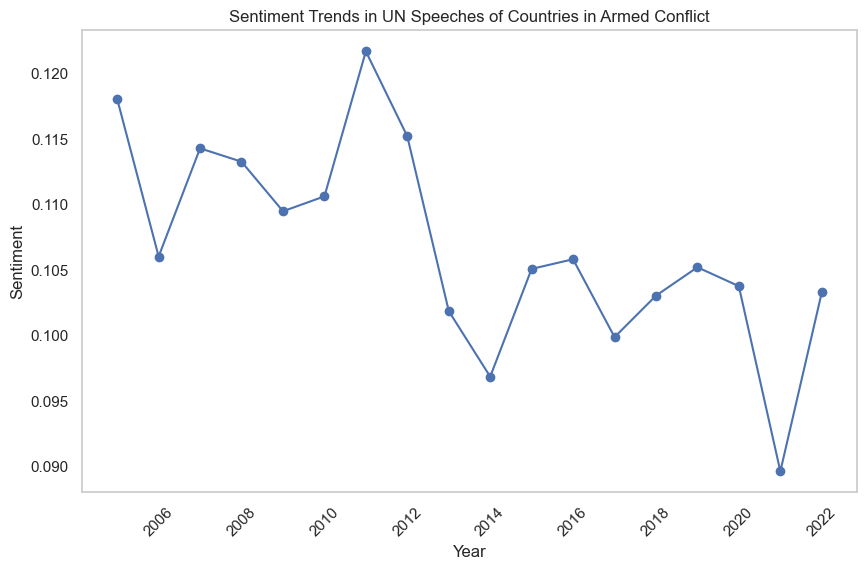

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

#convert year to datetime
conflict_sentiment['year'] = pd.to_datetime(conflict_sentiment['year'].astype(str), format='%Y')

# Now plot your data
plt.figure(figsize=(10, 6))
plt.plot(conflict_sentiment['year'], conflict_sentiment['sentiment'], marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title('Sentiment Trends in UN Speeches of Countries in Armed Conflict')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.grid()
plt.show()


#### 1.4. Inspect the sentiment by region

In [54]:
#calculate average sentiment by region per year
average_sentiment_year_region = conflict_speeches.groupby(['year', 'region'])['sentiment'].mean().reset_index()

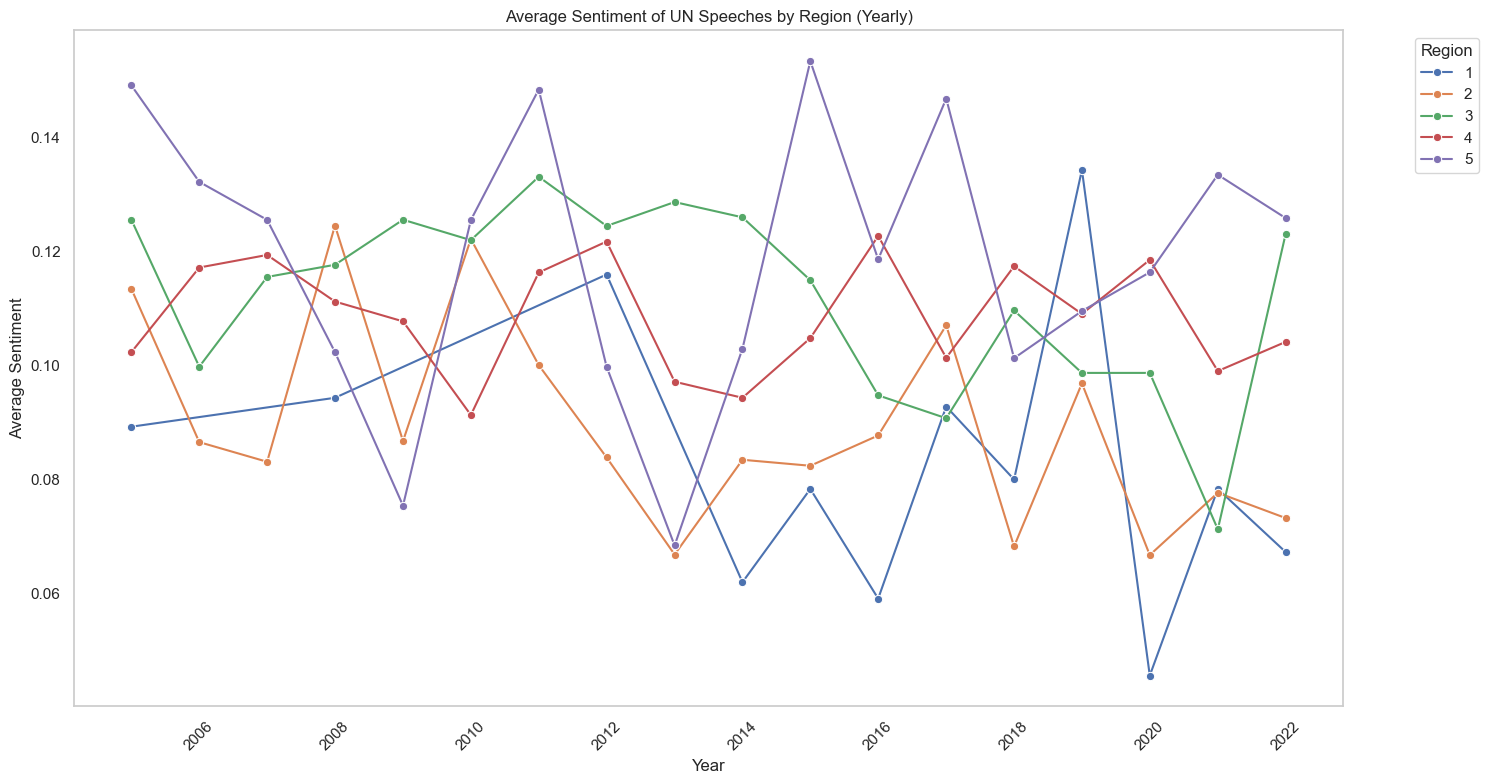

In [56]:
#convert year to datetime
average_sentiment_year_region['year'] = pd.to_datetime(average_sentiment_year_region['year'].astype(str), format='%Y')

#plot the average sentiment by region per year
plt.figure(figsize=(15, 8))
sns.lineplot(data=average_sentiment_year_region, x='year', y='sentiment', hue='region', marker='o')
plt.title('Average Sentiment of UN Speeches by Region (Yearly)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
